In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import kstest

In [2]:
df = pd.read_csv('data.csv')
data = df[['ED','AF','TB','PSA','TR','VP','PIR']].drop_duplicates()
data['ID'] = range(data.shape[0])
data.head()

,ED,AF,TB,PSA,TR,VP,PIR,ID
0,63.000000,No,inical,1240.00,anormal,218.0,5,0
1,79.794661,No,inical,169.50,anormal,23.0,5,1
2,69.921971,No,inical,196.00,anormal,85.0,5,2
3,79.110198,No,inical,141.93,anormal,43.0,5,3
4,75.704312,Si,inical,103.18,normal,52.0,5,4


In [3]:
corr = data.loc[:,'ED':].corr()
corr.style.background_gradient(cmap='coolwarm')

,ED,PSA,VP,PIR,ID
ED,1.000000,0.090823,0.090892,0.215547,-0.119777
PSA,0.090823,1.000000,0.074203,0.079068,0.046740
VP,0.090892,0.074203,1.000000,-0.144445,0.181898
PIR,0.215547,0.079068,-0.144445,1.000000,-0.188687
ID,-0.119777,0.046740,0.181898,-0.188687,1.000000


## Gaussian Copula Model

In [22]:
from sdv.tabular import GaussianCopula

data = data[data.PSA<2000]

model = GaussianCopula(
    primary_key='ID',
    #field_distributions={
    #'PSA' : 'gamma'
    #},
    enforce_min_max_values=False
)
model.fit(data)
distributions = model.get_distributions()

new_data = model.sample(num_rows=data.shape[0])

In [23]:
def evaluate_dists(original_values, synth_values):
    
    x, y = original_values, synth_values
    d = {'Group': ['real']*len(x) + ['synth']*len(y), 'Values': list(x) + list(y)}   
    df = pd.DataFrame(d)
    
    # visual inspection: historgrams and Q-Q plot
    
    plt.figure(figsize=(15, 8))
        
    plt.subplot(2, 2, 1)
    plt.hist(x)
    plt.xlim([0, max(list(x) + list(y))])
    plt.ylim([0, len(x)])
    plt.title('Real')
    
    plt.subplot(2, 2, 2)
    plt.hist(y)
    plt.xlim([0, max(list(x) + list(y))])
    plt.ylim([0, len(x)])
    plt.title('Synth')
    
    plt.subplot(2, 2, 3)    
    values = df['Values'].values
    values_s = df.loc[df.Group=='synth', 'Values'].values
    values_r = df.loc[df.Group=='real', 'Values'].values
    df_pct = pd.DataFrame()
    df_pct['q_synth'] = np.percentile(values_s, range(100))
    df_pct['q_real'] = np.percentile(values_r, range(100))
    plt.scatter(x='q_real', y='q_synth', data=df_pct, label='Actual fit');
    sns.lineplot(x='q_real', y='q_real', data=df_pct, color='r', label='Line of perfect fit');
    plt.xlabel('Quantile of real values')
    plt.ylabel('Quantile of synth values')
    plt.legend()
    plt.title("QQ plot");
    
    plt.subplot(2, 2, 4)
    df_ks = pd.DataFrame()
    df_ks['Values'] = np.sort(df['Values'].unique())
    df_ks['F_real'] = df_ks['Values'].apply(lambda x: np.mean(values_r<=x))
    df_ks['F_synth'] = df_ks['Values'].apply(lambda x: np.mean(values_s<=x))
    k = np.argmax( np.abs(df_ks['F_real'] - df_ks['F_synth']))
    ks_stat = np.abs(df_ks['F_synth'][k] - df_ks['F_real'][k])
    
    y_ks = (df_ks['F_synth'][k] + df_ks['F_real'][k])/2
    plt.plot('Values', 'F_real', data=df_ks, label='Real')
    plt.plot('Values', 'F_synth', data=df_ks, label='Synth')
    plt.errorbar(x=df_ks['Values'][k], y=y_ks, yerr=ks_stat/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
    plt.legend(loc='center right');
    plt.title("Kolmogorov-Smirnov Test");
    
    plt.show()
    
    # statistical tests
    
    # Levene’s test for homogeneity of variances: significant p-value = unequal variances
    # t-test test for difference between the means: significant p-value = different means
    
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    
    stat, lavene_pvalue = stats.levene(x, y)
       
    if lavene_pvalue < 0.05:
        
        t, p = stats.ttest_ind(x, y, equal_var = False)
        print(f" Welch's t-test: statistic={t:.4f}, p-value={p:.4f}")
        print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    
    else:
        
        t, p = stats.ttest_ind(x, y)
        print(f"t-test: statistic={t:.4f}, p-value={p:.4f}")
        print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    
    # Kolmogorov-Smirnov Test for difference in the maximum absolute difference between the two cumulative distributions
    # significant p-value = different distributions
    
    stat, p_value = kstest(values_s, values_r)
    print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

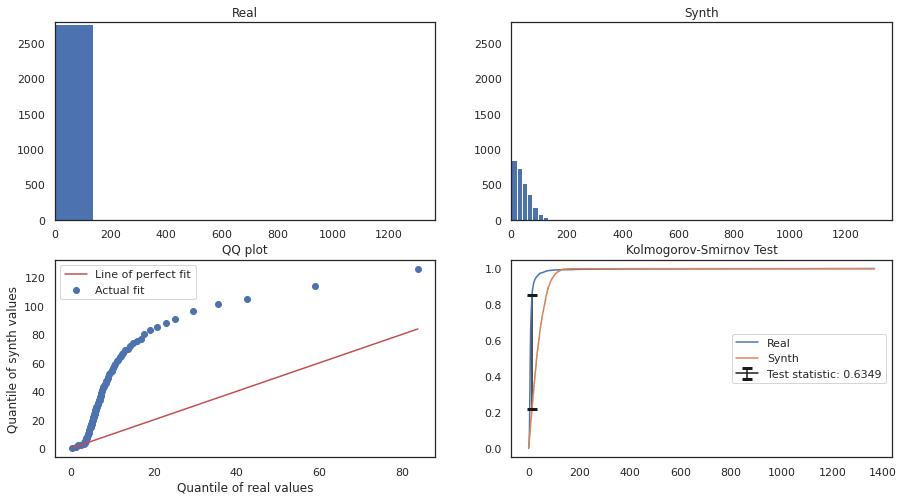

 Welch's t-test: statistic=-24.8227, p-value=0.0000
Welch-Satterthwaite Degrees of Freedom= 4660.7462
 Kolmogorov-Smirnov Test: statistic=0.6349, p-value=0.0000


In [24]:
evaluate_dists(data.PSA.values, new_data.PSA.values)

In [25]:
from sdv.evaluation import evaluate
evaluate(new_data, data, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.829850,0.829850,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.871358,0.871358,0.0,1.0,MAXIMIZE,None


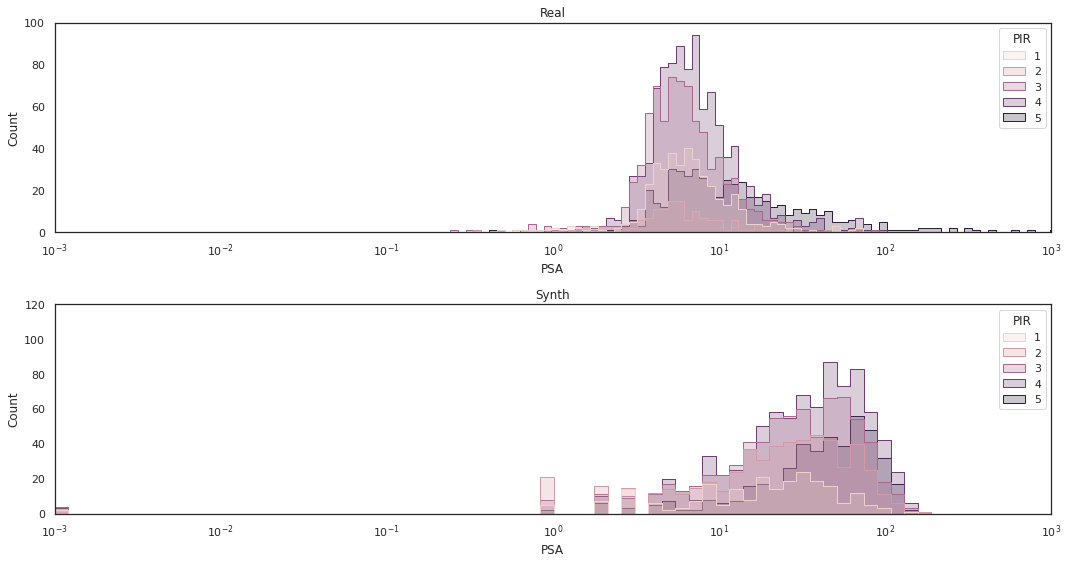

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

sns.histplot(data, x="PSA", hue="PIR", element="step", log_scale=True, ax=ax[0])
ax[0].set_xlim(10**-3,10**3)
ax[0].set_ylim(0,100)
ax[0].set_title('Real')

new_data["PSA"] = new_data["PSA"] + 0.001
sns.histplot(new_data, x="PSA", hue="PIR", element="step", log_scale=True, ax=ax[1])
ax[1].set_xlim(10**-3,10**3)
ax[1].set_ylim(0,120)
ax[1].set_title('Synth')

fig.tight_layout()

## CTGAN

In [15]:
from sdv.tabular import CTGAN

model = CTGAN(
    primary_key='ID',
    epochs=500,
    batch_size=100,
    #log_frequency=False,
)

model.fit(data)

new_data = model.sample(num_rows=data.shape[0])

In [16]:
from sdv.evaluation import evaluate
evaluate(new_data, data, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.936507,0.936507,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.806455,0.806455,0.0,1.0,MAXIMIZE,None


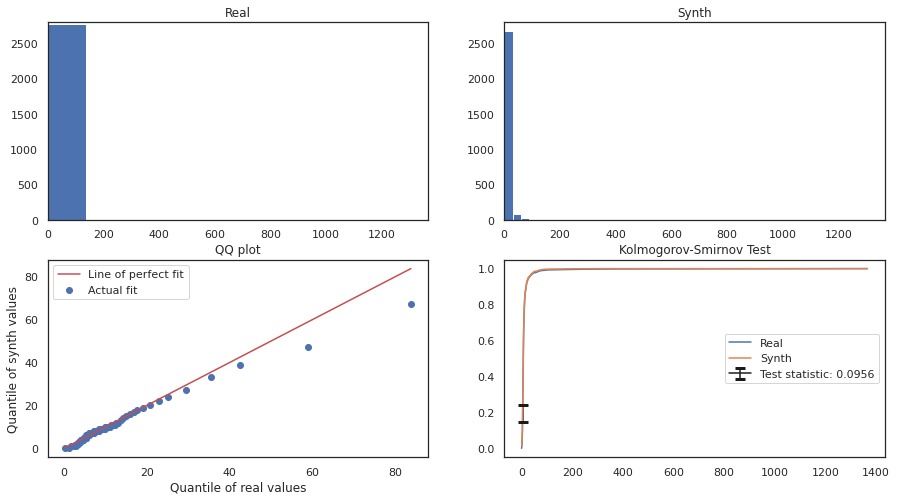

 Welch's t-test: statistic=2.7548, p-value=0.0059
Welch-Satterthwaite Degrees of Freedom= 3301.2112
 Kolmogorov-Smirnov Test: statistic=0.0956, p-value=0.0000


In [17]:
evaluate_dists(data.PSA.values, new_data.PSA.values)

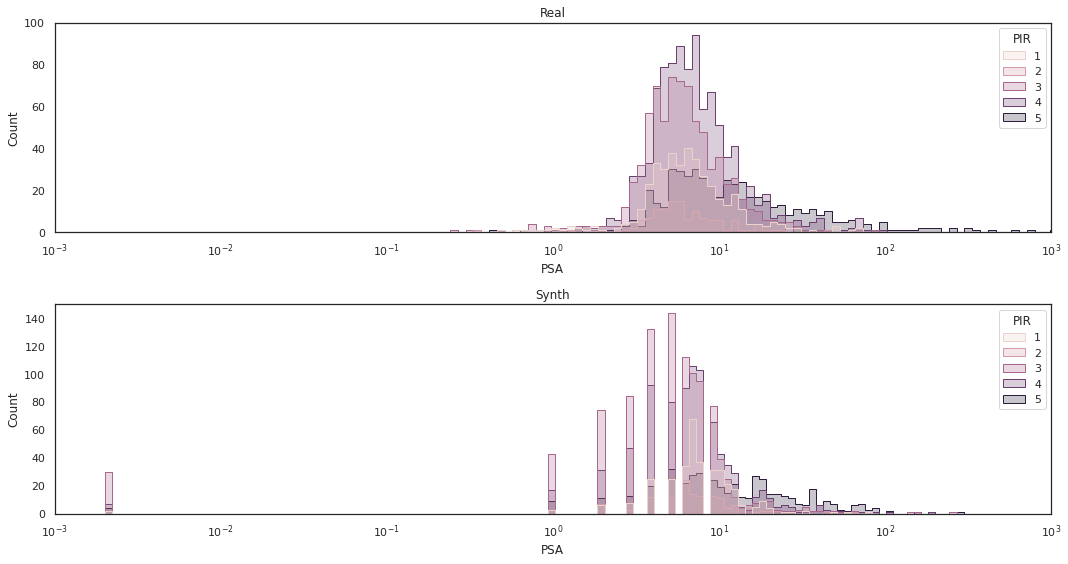

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

sns.histplot(data, x="PSA", hue="PIR", element="step", log_scale=True, ax=ax[0])
ax[0].set_xlim(10**-3,10**3)
ax[0].set_ylim(0,100)
ax[0].set_title('Real')

new_data["PSA"] = new_data["PSA"] + 0.001
sns.histplot(new_data, x="PSA", hue="PIR", element="step", log_scale=True, ax=ax[1])
ax[1].set_xlim(10**-3,10**3)
ax[1].set_ylim(0,150)
ax[1].set_title('Synth')

fig.tight_layout()

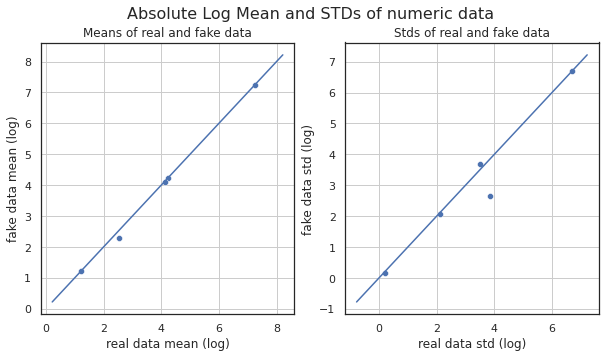

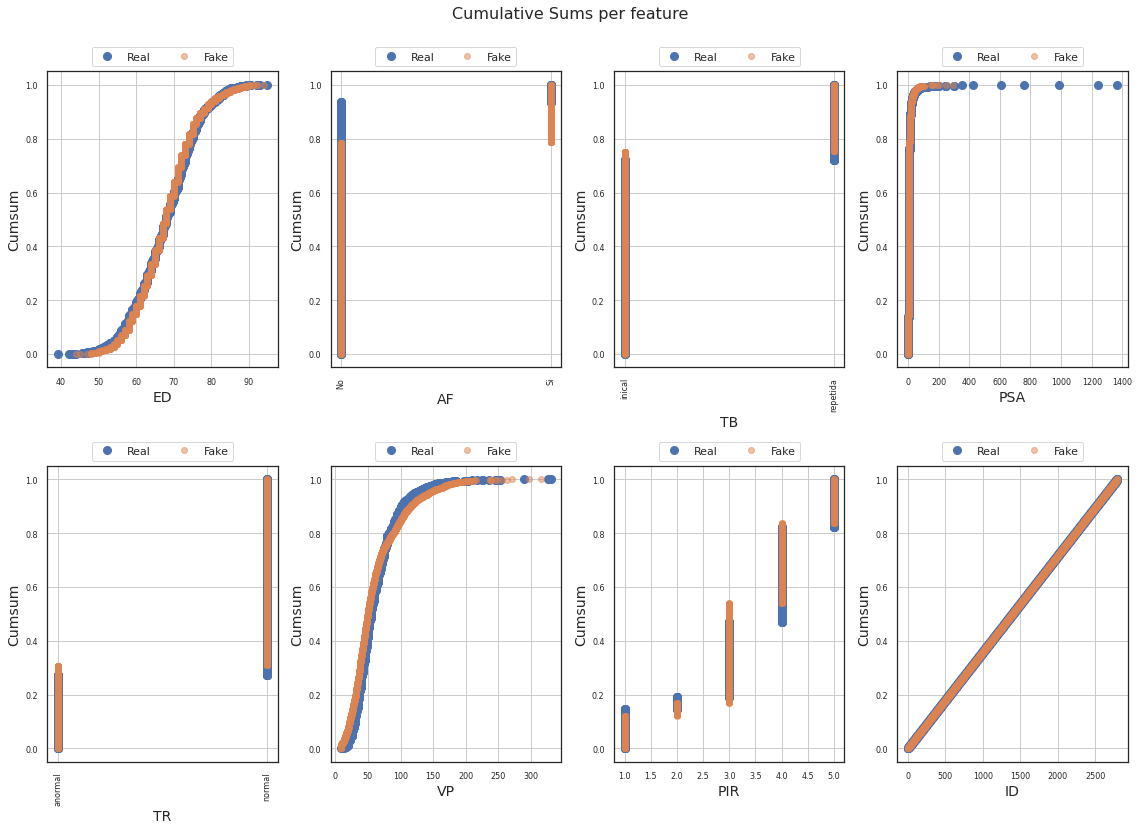

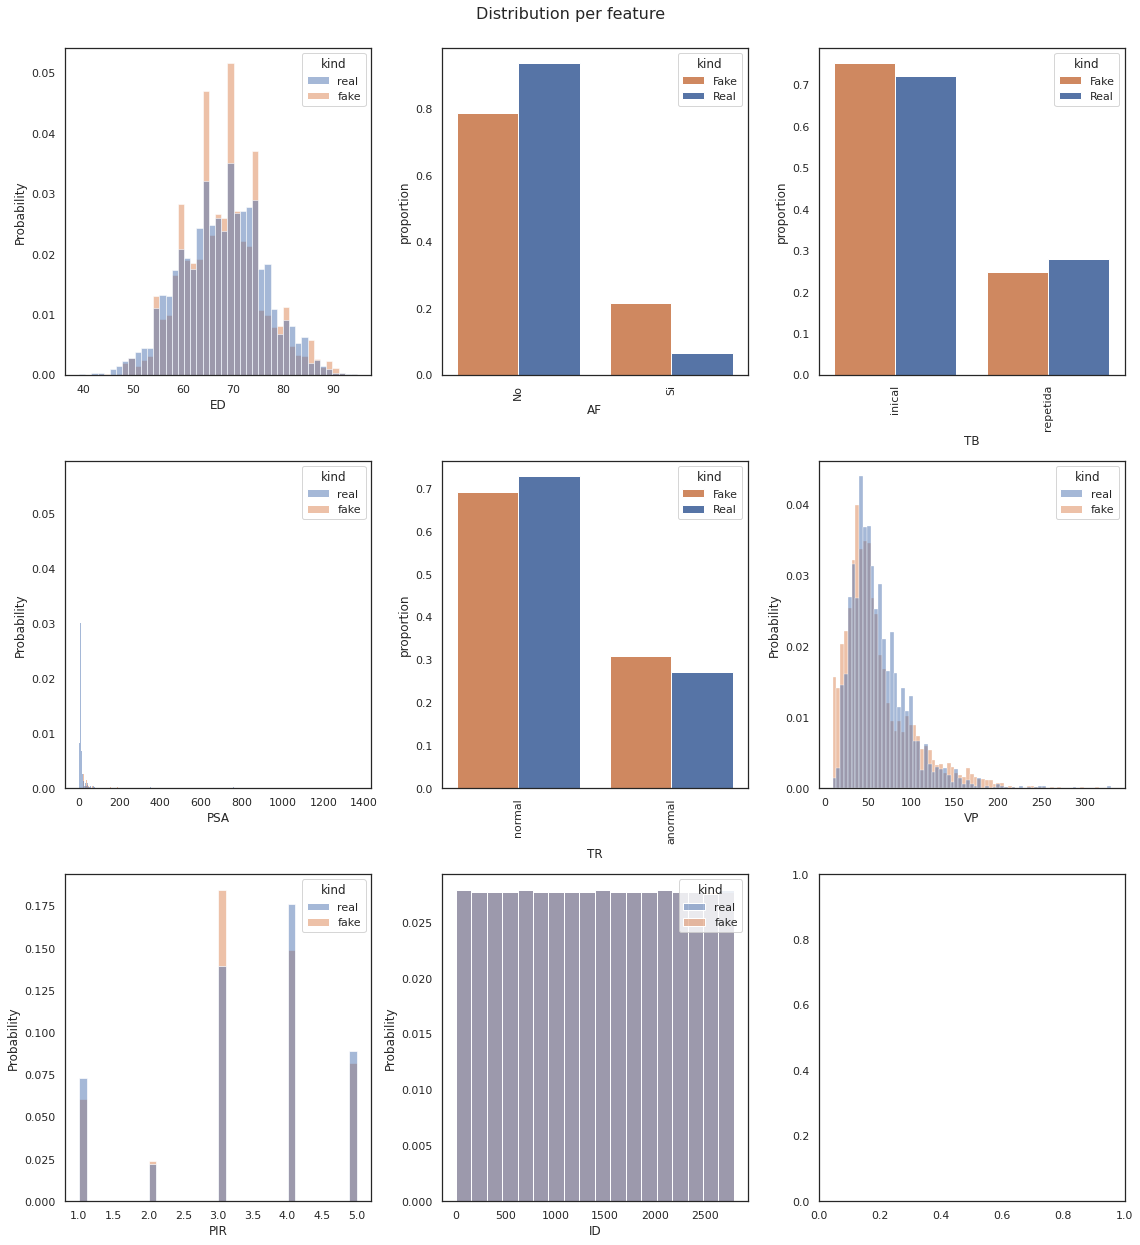

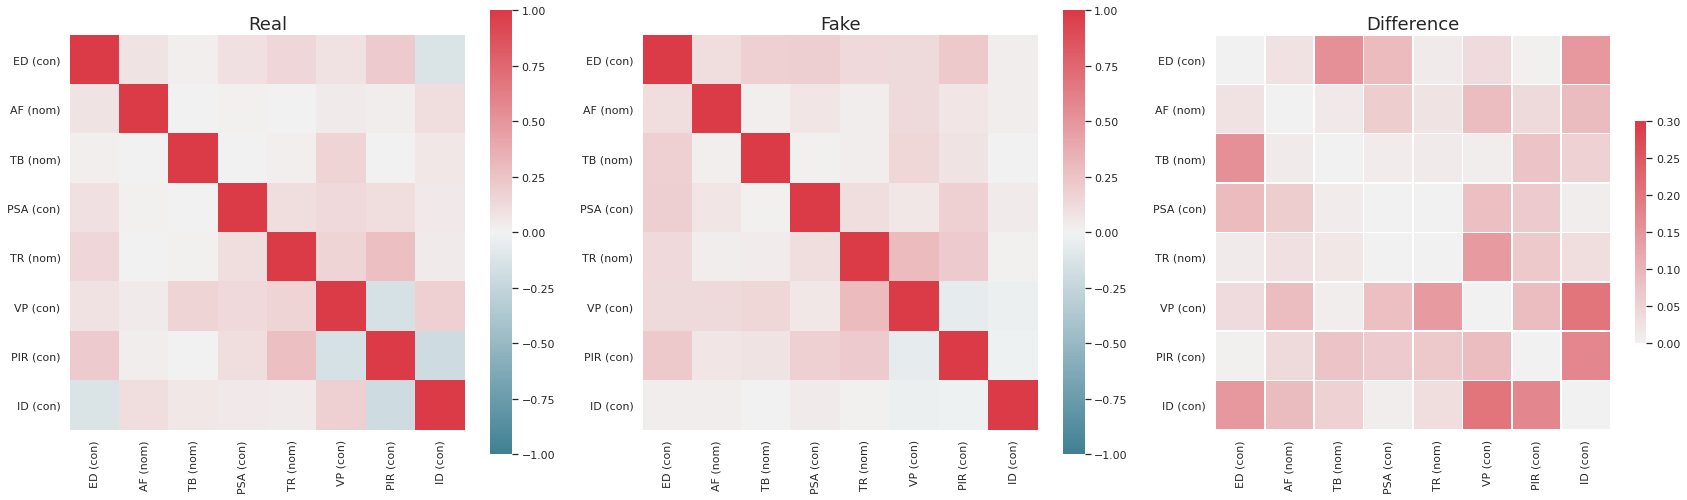

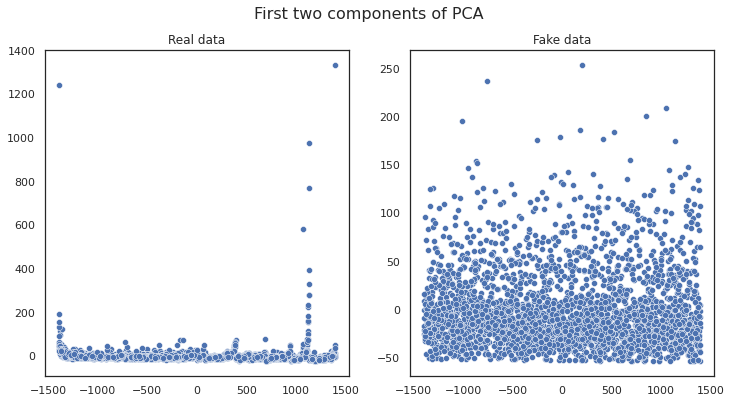

In [20]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, new_data)
table_evaluator.visual_evaluation()

In [14]:
data.loc[:,'ED':].drop_duplicates().shape

(2794, 8)